In [738]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

data = '230802_Axial_z2_8Data'
dataname = data+'_02'
filename = 'myData/'+data+'.csv'
SD1 = pd.read_csv(filename)
SD1=SD1.iloc[:,:13]
SensorData1 = SD1

In [739]:
SD1.sample(5)

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
228809,41,35,45,37,45,43,62,56,50.16,0,154,0,7.2
67833,38,25,43,46,50,52,58,62,54.14,0,44,0,8.0
114766,35,33,48,33,42,56,58,61,49.58,0,76,0,7.2
150212,35,32,49,42,37,46,61,60,56.35,0,100,0,8.0
174036,37,36,46,42,43,51,66,63,10.71,0,118,0,1.6


In [740]:
SDreal = SD1

In [741]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
count,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.0,235079.000000,235079.0,235079.000000
mean,37.855602,35.384769,47.421667,43.813399,45.391064,50.105960,60.760553,60.335164,28.366040,0.0,78.786263,0.0,4.397089
std,29.678911,77.255275,58.529797,71.599723,50.843784,71.695767,77.129128,50.722240,28.043329,0.0,46.194791,0.0,2.298731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-483.760000,0.0,0.000000,0.0,0.800000
25%,36.000000,33.000000,45.000000,41.000000,44.000000,48.000000,59.000000,59.000000,11.960000,0.0,38.000000,0.0,2.400000
50%,38.000000,35.000000,47.000000,43.000000,46.000000,50.000000,60.000000,61.000000,29.310000,0.0,78.000000,0.0,4.000000
75%,40.000000,37.000000,49.000000,46.000000,47.000000,52.000000,62.000000,62.000000,43.440000,0.0,118.000000,0.0,6.400000
max,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,10001.950000,0.0,158.000000,0.0,8.000000


In [742]:
# SDreal 값이 0보다 작은데 encoder 인 것 제거
SDreal = SDreal[~((SDreal < 0)&(SDreal.columns != "encoder")).any(axis=1)]
#SDreal = SDreal[~((SDreal['z'] % 2 == 0) & (SDreal['z'] % 4 != 0))]

# SDreal 값이 100보다 크거나 0인데, 'theta', 'z', 'Force' 열이 아닌 것 제거
SDreal = SDreal[~(((SDreal >= 80)|(SDreal == 0) ) & 
                 (SDreal.columns != "theta") &
                 (SDreal.columns != "z") &
                 (SDreal.columns != "Force") &
                  (SDreal.columns != "encoder")).any(axis=1)]

# SDreal 값이 8191이거나 8190인 것 제거
SDreal = SDreal[~((SDreal == 8191) | (SDreal == 8190)).any(axis=1)]

# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

SDreal = SDreal[~((SDreal >= 800) & (SDreal.columns == "Force")).any(axis=1)]
SDreal = SDreal[~((SDreal <= -300) & (SDreal.columns == "Force")).any(axis=1)]

k = 3
for col in SDreal.columns:
    mean = SDreal[col].mean()
    std = SDreal[col].std()

    outliers = (SDreal[col] < mean - k*std) | (SDreal[col] > mean + k*std)
    SDreal = SDreal[~outliers]


SDreal = SDreal[SDreal["r"] >= 0.8*3]
SDreal = SDreal[SDreal["z"] <= 150]
SDreal = SDreal[SDreal["z"] >= 10]
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
count,128966.000000,128966.000000,128966.000000,128966.000000,128966.000000,128966.000000,128966.000000,128966.000000,128966.000000,128966.0,128966.000000,128966.0,128966.000000
mean,37.150280,34.316983,47.071515,43.210117,44.942256,50.179070,60.054286,60.847316,36.829853,0.0,78.063753,0.0,5.396374
std,2.698876,3.030229,3.199770,3.745040,3.302577,3.329749,2.755081,2.888110,11.935032,0.0,40.066774,0.0,1.546176
min,29.000000,26.000000,38.000000,33.000000,36.000000,40.000000,52.000000,50.000000,10.870000,0.0,10.000000,0.0,3.200000
25%,35.000000,32.000000,45.000000,41.000000,43.000000,48.000000,58.000000,60.000000,26.770000,0.0,44.000000,0.0,4.000000
50%,37.000000,34.000000,47.000000,43.000000,45.000000,51.000000,60.000000,61.000000,36.500000,0.0,78.000000,0.0,5.600000
75%,39.000000,36.000000,49.000000,46.000000,47.000000,52.000000,62.000000,63.000000,46.060000,0.0,112.000000,0.0,6.400000
max,46.000000,44.000000,56.000000,53.000000,54.000000,60.000000,69.000000,70.000000,68.550000,0.0,150.000000,0.0,8.000000


In [743]:
def normalize_dataframe(df, columns=None):
    # columns가 제공되지 않았다면 df의 모든 칼럼을 대상으로 함
    if columns is None:
        columns = df.columns

    for column in columns:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    
    return df

# 모든 칼럼을 대상으로 정규화
SDreal_normalized = normalize_dataframe(SDreal.copy())
#SDreal_normalized = normalize_dataframe(SDreal, ['r', 'Force', 'z'])
SDreal = SDreal_normalized
SDreal

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
15753,0.647059,0.555556,0.500000,0.55,0.777778,0.50,0.411765,0.65,0.022538,NaN,0.0,NaN,0.0
15754,0.647059,0.555556,0.500000,0.55,0.777778,0.50,0.411765,0.65,0.022538,NaN,0.0,NaN,0.0
15755,0.647059,0.555556,0.500000,0.55,0.777778,0.50,0.411765,0.65,0.023752,NaN,0.0,NaN,0.0
15756,0.647059,0.555556,0.444444,0.55,0.777778,0.50,0.411765,0.65,0.023058,NaN,0.0,NaN,0.0
15757,0.588235,0.555556,0.444444,0.55,0.666667,0.50,0.470588,0.65,0.023058,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223258,0.647059,0.444444,0.500000,0.35,0.333333,0.25,0.588235,0.05,0.833564,NaN,1.0,NaN,1.0
223259,0.647059,0.444444,0.388889,0.35,0.500000,0.25,0.588235,0.05,0.833044,NaN,1.0,NaN,1.0
223260,0.647059,0.444444,0.388889,0.35,0.500000,0.25,0.647059,0.05,0.833911,NaN,1.0,NaN,1.0
223261,0.647059,0.444444,0.388889,0.35,0.500000,0.25,0.647059,0.00,0.832524,NaN,1.0,NaN,1.0


In [744]:
SDy = SDreal.iloc[:,[8,10]]
SDy.describe()

,Force,z
count,128966.000000,128966.000000
mean,0.450067,0.486170
std,0.206918,0.286191
min,0.000000,0.000000
25%,0.275659,0.242857
50%,0.444348,0.485714
75%,0.610090,0.728571
max,1.000000,1.000000


In [745]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# SDreal.hist(bins=50, figsize=(20,15))
# plt.savefig('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/SensorCallbi/LABS_v3/savefig/'+dataname+'_hist230320.png')
# plt.show()

In [746]:
X = SDreal.iloc[:,0:8]
y = SDreal.iloc[:,[8,10]]

In [747]:
X

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07
15753,0.647059,0.555556,0.500000,0.55,0.777778,0.50,0.411765,0.65
15754,0.647059,0.555556,0.500000,0.55,0.777778,0.50,0.411765,0.65
15755,0.647059,0.555556,0.500000,0.55,0.777778,0.50,0.411765,0.65
15756,0.647059,0.555556,0.444444,0.55,0.777778,0.50,0.411765,0.65
15757,0.588235,0.555556,0.444444,0.55,0.666667,0.50,0.470588,0.65
...,...,...,...,...,...,...,...,...
223258,0.647059,0.444444,0.500000,0.35,0.333333,0.25,0.588235,0.05
223259,0.647059,0.444444,0.388889,0.35,0.500000,0.25,0.588235,0.05
223260,0.647059,0.444444,0.388889,0.35,0.500000,0.25,0.647059,0.05
223261,0.647059,0.444444,0.388889,0.35,0.500000,0.25,0.647059,0.00


In [748]:
y.sample(5)

,Force,z
161062,0.501214,0.700000
55455,0.518204,0.185714
212990,0.346914,0.957143
186515,0.237171,0.828571
209702,0.268204,0.942857


In [749]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)

In [750]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  102140 ea 79 %    X_valid:  25536 ea 19 %    X_test:  1290 ea 1 %


In [751]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [752]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230802_Axial_z2_8Data_02_SS.pkl']

In [753]:
from tensorflow import keras
model = keras.models.Sequential([   
    keras.layers.Dense(128, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),            
    keras.layers.Dense(64, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),            
    keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),            
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(8, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(2)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9))
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_152 (Dense)           (None, 128)               1152      
                                                                 
 dense_153 (Dense)           (None, 64)                8256      
                                                                 
 dense_154 (Dense)           (None, 32)                2080      
                                                                 
 dense_155 (Dense)           (None, 16)                528       
                                                                 
 dense_156 (Dense)           (None, 8)                 136       
                                                                 
 dense_157 (Dense)           (None, 2)                 18        
                                                                 
Total params: 12,170
Trainable params: 12,170
Non-tra

## Callback (best, early stopping, tensorboard)

In [754]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230320_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [755]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [756]:
dataname

'230802_Axial_z2_8Data_02'

In [757]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 4
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
3192/3192 [==============================] - 6s 2ms/step - loss: 0.0160 - val_loss: 0.0135
Epoch 2/300
3192/3192 [==============================] - 6s 2ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 3/300
3192/3192 [==============================] - 6s 2ms/step - loss: 0.0124 - val_loss: 0.0130
Epoch 4/300
3192/3192 [==============================] - 6s 2ms/step - loss: 0.0122 - val_loss: 0.0123
Epoch 5/300
3192/3192 [==============================] - 6s 2ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 6/300
3192/3192 [==============================] - 6s 2ms/step - loss: 0.0119 - val_loss: 0.0128
Epoch 7/300
3192/3192 [==============================] - 6s 2ms/step - loss: 0.0118 - val_loss: 0.0131
Epoch 8/300
3192/3192 [==============================] - 6s 2ms/step - loss: 0.0118 - val_loss: 0.0125
Epoch 9/300
3192/3192 [==============================] - 6s 2ms/step - loss: 0.0117 - val_loss: 0.0124
Epoch 10/300
3192/3192 [==============================] - 6s 2ms/step - l

In [758]:
# %load_ext tensorboard
# %tensorboard --logdir=./mylog/230320_Data --port=2322

In [759]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v1/myModel/'+dataname+'.h5')

In [760]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

valid_predictions_df=pd.DataFrame(valid_predictions)
valid_predictions_df.columns = ["valid_force","valid_z"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r"]
valid_predictions_df

k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
#k_df.columns  = ["force","z","r"]
k_df.columns  = ["force","z"]
k_df.describe()

798/798 [==============================] - 1s 699us/step


,force,z
count,25536.000000,25536.000000
mean,0.449477,0.487097
std,0.206455,0.286809
min,0.000347,0.000000
25%,0.277219,0.242857
50%,0.443655,0.485714
75%,0.609917,0.728571
max,0.988904,1.000000


In [761]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
n = k_df.shape[1]
for i in range(0,n):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr

corr
86.21% force
92.17% z


,force,z,valid_force,valid_z
force,1.000000,0.225279,0.862088,0.277607
z,0.225279,1.000000,0.285344,0.921666
valid_force,0.862088,0.285344,1.000000,0.330249
valid_z,0.277607,0.921666,0.330249,1.000000


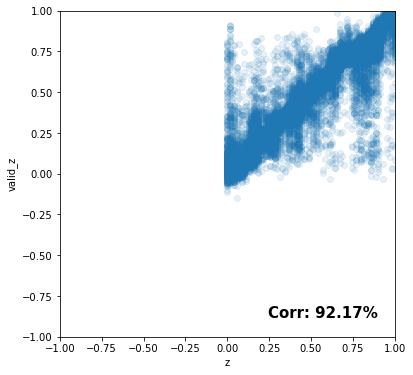

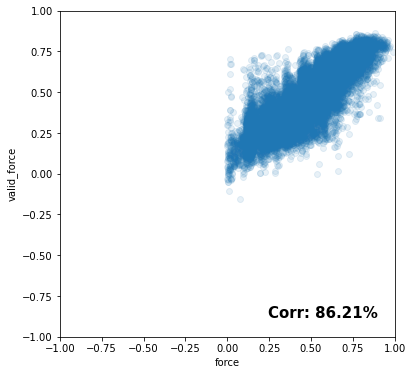

In [762]:
import pandas as pd
import os
import matplotlib.pyplot as plt

alpa = 0.1
output_dir = "myLearningData/savefig"  # 저장할 폴더 이름

# 폴더가 없는 경우 폴더를 생성합니다.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

fields = ['z', 'force']

for field in fields:
    plt.figure(figsize=(6, 6))  # Set the figure size to 1:1
    plt.scatter(ValidPre[field], ValidPre[f"valid_{field}"], alpha=alpa)
    plt.xlabel(field)
    plt.ylabel(f"valid_{field}")
    plt.xlim(-1, 1)  # x축 범위 설정
    plt.ylim(-1, 1)  # y축 범위 설정

    # Compute the correlation value to be added
    corr_value = format(corr[f"valid_{field}"][field]*100,'.2f') + '%'
    plt.text(0.95, 0.05, f'Corr: {corr_value}', ha='right', va='bottom', 
             transform=plt.gca().transAxes, fontsize=15, weight='bold')

    plt.savefig(os.path.join(output_dir, f"{dataname}_{field}.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장
    plt.show()
